In [622]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from typing import List
import numpy as np
from sklearn.preprocessing import StandardScaler
import itertools as itertools
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
import pandas as pd

In [623]:
# load training and test data set from a text file
df = pd.read_csv("./data/South African Heart Disease.txt")
# encode famhist with dummy 0-1 variable
df['famhist'] = pd.get_dummies(df['famhist'])['Present']
df["famhist"] = df["famhist"].astype(int)
target = 'chd'
features = ['sbp', 'tobacco', 'ldl', 'obesity', 'alcohol', 'age']
df[features + [target]].head()

,sbp,tobacco,ldl,obesity,alcohol,age,chd
0,160,12.00,5.73,25.30,97.20,52,1
1,144,0.01,4.41,28.87,2.06,63,1
2,118,0.08,3.48,29.14,3.81,46,0
3,170,7.50,6.41,31.99,24.26,58,1
4,134,13.60,3.50,25.99,57.34,49,1


In [624]:
X, y = df[features].values, df[target].values

## Import splines from library

In [711]:
import src.spline_estimators as se
from importlib import reload
reload(se)

<module 'src.spline_estimators' from '/Users/abhilashdhal/Desktop/ESL_python/ESL_python/src/spline_estimators.py'>

## Initialize splines objects

In [712]:
cubic_spl = se.SplineEstimators(target_dofs=4, method_name='ls')
natural_cubic_spl = se.SplineEstimators(target_dofs=4, method_name='ns')

## Get Knots

In [713]:
knots_ns = natural_cubic_spl._compute_knots(X)
knots_cs = cubic_spl._compute_knots(X)

In [714]:
natural_cubic_spl.knots

In [715]:
knots_ns

[array([101., 124., 134., 148., 218.]),
 array([ 0.    ,  0.0525,  2.    ,  5.5   , 31.2   ]),
 array([ 0.98  ,  3.2825,  4.34  ,  5.79  , 15.33  ]),
 array([14.7   , 22.985 , 25.805 , 28.4975, 46.58  ]),
 array([  0.    ,   0.51  ,   7.51  ,  23.8925, 147.19  ]),
 array([15., 31., 45., 55., 64.])]

In [716]:
knots_cs

[array([124., 134., 148.]),
 array([0.0525, 2.    , 5.5   ]),
 array([3.2825, 4.34  , 5.79  ]),
 array([22.985 , 25.805 , 28.4975]),
 array([ 0.51  ,  7.51  , 23.8925]),
 array([31., 45., 55.])]

## Show knots 

In [717]:
knots_ns

[array([101., 124., 134., 148., 218.]),
 array([ 0.    ,  0.0525,  2.    ,  5.5   , 31.2   ]),
 array([ 0.98  ,  3.2825,  4.34  ,  5.79  , 15.33  ]),
 array([14.7   , 22.985 , 25.805 , 28.4975, 46.58  ]),
 array([  0.    ,   0.51  ,   7.51  ,  23.8925, 147.19  ]),
 array([15., 31., 45., 55., 64.])]

In [718]:
knots_cs

[array([124., 134., 148.]),
 array([0.0525, 2.    , 5.5   ]),
 array([3.2825, 4.34  , 5.79  ]),
 array([22.985 , 25.805 , 28.4975]),
 array([ 0.51  ,  7.51  , 23.8925]),
 array([31., 45., 55.])]

## Transform X to new basis terms

In [719]:
i = 0
expanded_basis_ns = natural_cubic_spl._calc_expanded_basis_ns(X[:, i:i+1], knots_ns[i])

In [720]:
expanded_basis_ns.shape

(462, 4)

In [721]:
i = 0
expanded_basis_cs = cubic_spl._calc_expanded_basis_cs(X[:, i:i+1], knots_cs[i])

In [722]:
knots_cs

[array([124., 134., 148.]),
 array([0.0525, 2.    , 5.5   ]),
 array([3.2825, 4.34  , 5.79  ]),
 array([22.985 , 25.805 , 28.4975]),
 array([ 0.51  ,  7.51  , 23.8925]),
 array([31., 45., 55.])]

In [723]:
expanded_basis_cs

array([[1.600000e+02, 2.560000e+04, 4.096000e+06, 4.665600e+04,
        1.757600e+04, 1.728000e+03],
       [1.440000e+02, 2.073600e+04, 2.985984e+06, 8.000000e+03,
        1.000000e+03, 0.000000e+00],
       [1.180000e+02, 1.392400e+04, 1.643032e+06, 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.080000e+02, 1.166400e+04, 1.259712e+06, 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.180000e+02, 1.392400e+04, 1.643032e+06, 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.320000e+02, 1.742400e+04, 2.299968e+06, 5.120000e+02,
        0.000000e+00, 0.000000e+00]])

In [724]:
X_ns = natural_cubic_spl.fit_transform(X)
X_cs = cubic_spl.fit_transform(X)

In [725]:
natural_cubic_spl.fit(X).dofs_

array([4, 4, 4, 4, 4, 4])

In [726]:
cubic_spl.fit(X).dofs_

array([3, 3, 3, 3, 3, 3])

## Analyze new basis using LR 

In [741]:
ncs_features = se.SplineEstimators(target_dofs=4, method_name='ls')
add_intercept = FunctionTransformer(
    lambda X: sm.add_constant(X), validate=True)
data_prep_pipeline = Pipeline([
                                ('scale_features', StandardScaler()),
                               ('expand_basis', ncs_features),
                               ('scale_basis', StandardScaler()),

                               ('add_intercept_column', add_intercept)

                               ])

# PAGE 146. At this point the model is like any other linear logistic model,
#           and the algorithms described in Section 4.4.1 apply
lr = LogisticRegression(
    solver='lbfgs', max_iter=100000, C=10e10, fit_intercept=False)
expanded_lr = Pipeline([('prepare', data_prep_pipeline),
                        ('logistic', lr)])

In [742]:
selected_ids = set(range(len(features)))
X_selected = X[:, sorted(list(selected_ids))]
# expand the basis of the selected features
X_selected_exp = data_prep_pipeline.fit_transform(X_selected)

In [743]:
X_selected

array([[1.600e+02, 1.200e+01, 5.730e+00, 2.530e+01, 9.720e+01, 5.200e+01],
       [1.440e+02, 1.000e-02, 4.410e+00, 2.887e+01, 2.060e+00, 6.300e+01],
       [1.180e+02, 8.000e-02, 3.480e+00, 2.914e+01, 3.810e+00, 4.600e+01],
       ...,
       [1.080e+02, 3.000e+00, 1.590e+00, 2.009e+01, 2.664e+01, 5.500e+01],
       [1.180e+02, 5.400e+00, 1.161e+01, 2.735e+01, 2.397e+01, 4.000e+01],
       [1.320e+02, 0.000e+00, 4.820e+00, 1.470e+01, 0.000e+00, 4.600e+01]])

In [744]:
# PAGE 146. We carried out a backward stepwise deletion process, dropping terms
#           from this model while preserving the group structure of each term,
#           rather than dropping one coefficient at a time. The AIC statistic
#           (Section 7.5) was used to drop terms, and all the terms remaining
#           in the final model would cause AIC to increase if deleted from the
#           model (see Table 5.1).
# calculates total deviance of a model on a data set
def deviance(X, y, model):
    return 2*log_loss(y, model.predict_proba(X), normalize=False)


# calculates total deviance of a model trained on features subset
def subset_deviance(model, selected_ids):
    X_selected = X[:, sorted(list(selected_ids))]
    model.fit(X_selected, y)
    return deviance(X_selected, y, model)

# calculates AIC of log-reg model trained on expanded features subset
def subset_aic(selected_ids):
    X_selected = X[:, sorted(list(selected_ids))]
    # expand the basis of the selected features
    X_selected_exp = data_prep_pipeline.fit_transform(X_selected)
    # fit the log-reg model to the expanded data and calculate its AIC
    lr = sm.Logit(
        y, X_selected_exp[:, :-1]
    ).fit_regularized(method='l1', maxiter=1000, disp=False)
    return lr.aic

# start with all features selected, store indices
selected_ids = set(range(len(features)))
current_aic = subset_aic(selected_ids)
current_deviance = subset_deviance(lr, selected_ids)
while True:
    stat = [(subset_aic(selected_ids - set([idx])),
             subset_deviance(expanded_lr, selected_ids - set([idx])),
             idx) for idx in selected_ids]
    min_aic, dev, feature_to_remove_idx = min(stat)
    if min_aic > current_aic:
        break
    selected_ids -= set([feature_to_remove_idx])
    current_aic, current_deviance = min_aic, dev
    print(f'REMOVE: {features[feature_to_remove_idx]}')

selected_ids = sorted(list(selected_ids))
# convert list of stats to dictionary
stat = {id: (aic, dev) for (aic, dev, id) in stat}

REMOVE: alcohol
REMOVE: sbp
REMOVE: obesity


In [745]:
X_cs_trans =data_prep_pipeline.fit_transform(X)

In [746]:
X_cs_trans

array([[ 1.        ,  1.05856354,  1.07056657, ...,  0.61397698,
         0.2975692 , -0.5032205 ],
       [ 1.        ,  0.27708929,  0.21169658, ...,  1.57701125,
         2.00439392,  2.72577772],
       [ 1.        , -0.99280637, -0.86189091, ...,  0.08868556,
        -0.63342609, -0.5032205 ],
       ...,
       [ 1.        , -1.48122778, -0.86189091, ...,  0.87662269,
         0.76306685, -0.5032205 ],
       [ 1.        , -0.99280637, -0.86189091, ..., -0.43660586,
        -0.78859198, -0.5032205 ],
       [ 1.        , -0.3090164 , -0.43245591, ...,  0.08868556,
        -0.63342609, -0.5032205 ]])

In [747]:
# refit the model to the selected features
X_selected = X[:, selected_ids]
expanded_lr.fit(X_selected, y)
# save min-max of the selected features to use in plotting
X_min, X_max = np.min(X_selected, axis=0), np.max(X_selected, axis=0)

In [748]:
print(f'    Terms   Df   Deviance      AIC      LRT   P-value')
print(f'-----------------------------------------------------')
print(f'     none          {current_deviance:.2f}   {current_aic:.2f}')
for i, feature_idx in enumerate(selected_ids):
    feature_aic, feature_dev = stat[feature_idx]
    lrt = feature_dev - current_deviance
    p_value = 1 - stats.chi2.cdf(lrt, df=ncs_features.dofs_[i])
    print(f'{features[feature_idx]:>9}{ncs_features.dofs_[i]:>4}'
          f'{feature_dev:>12.2f}{feature_aic:9.2f}{lrt:>9.3f} {p_value:9.3f}')

    Terms   Df   Deviance      AIC      LRT   P-value
-----------------------------------------------------
     none          488.69   514.82
  tobacco   3      505.05   523.29   16.358     0.001
      ldl   3      501.47   519.61   12.777     0.005
      age   3      517.70   533.76   29.007     0.000


In [749]:
# estimate the covariance matrix
H = data_prep_pipeline.transform(X_selected)
predProbs = expanded_lr.predict_proba(X_selected)
W = np.diagflat(np.product(predProbs, axis=1))
cov = np.linalg.inv(H.T @ W @ H)



In [750]:
X_selected.shape

(462, 3)

In [751]:
# linspace selected features and calculate their basis expansions
x_vals = np.vstack([np.linspace(X_min[i], X_max[i], 100)
                    for i in range(X_min.shape[0])]).T


In [752]:
x_vals_exp = data_prep_pipeline.transform(x_vals)

# drop rows and columns for intercepts
x_vals_exp = x_vals_exp[:, 1:]
cov = cov[1:, 1:]

In [753]:
def plot_term_natural_spline_function(ax, feature_idx, name):
    basis_start, basis_end = ncs_features.positions_[feature_idx]

    # calculate feature expansion matrix, feature cov and feature err
    feature_exp = x_vals_exp[:, basis_start:basis_end+1]
    feature_lr_coef = lr.coef_[:, basis_start+1:basis_end+2].T
    feature_cov = cov[basis_start:basis_end+1, basis_start:basis_end+1]
    feature_err = 2*np.sqrt(np.diag(feature_exp @ feature_cov @ feature_exp.T))
    feature_x_vals = x_vals[:, feature_idx]
    feature_y_vals = np.squeeze(feature_exp @ feature_lr_coef)
    # plot shaded region
    ax.fill_between(feature_x_vals,
                    feature_y_vals - feature_err,
                    feature_y_vals + feature_err,
                    color='#FFEC8B')
    # plot function line

    ax.plot(feature_x_vals, feature_y_vals, color='#00FF00', linewidth=0.8)
    # plot bottom red lines representing samples
    y_from, y_to = ax.get_ylim()
    for i in range(X_selected.shape[0]):
        x = X_selected[i, feature_idx]
        ax.plot([x, x], [y_from, y_from+(y_to-y_from)*0.02],
                color='red', linewidth=0.5)
    ax.set_ylim(y_from, y_to)
    # title the plot and set ticks
    for l in ax.get_yticklabels() + ax.get_xticklabels():
        l.set_fontsize(6)
    ax.set_xlabel(f'{name}',  fontsize=8)
    ax.set_ylabel(f'f({name})', fontsize=8)

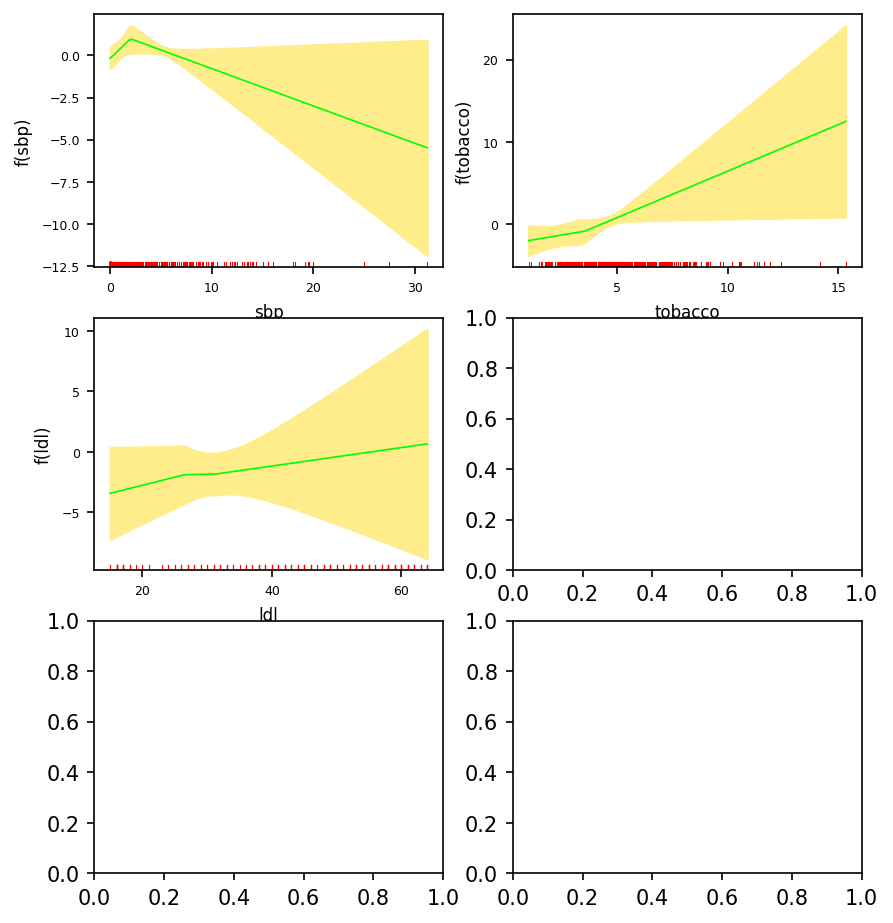

In [754]:
import matplotlib.pyplot as plt
# PAGE 147. FIGURE 5.4. Fitted natural-spline functions for each of the terms
#           in the final model selected by the stepwise procedure. Included are
#           pointwise standard-error bands. The rug plot at the base of each
#           figure indicates the location of each of the sample values for that
#           variable (jittered to break ties).
fig, axarr = plt.subplots(3, 2, figsize=(3.3*2, 2.3*3), dpi=150)
plt.subplots_adjust(bottom=0.05)
plot_term_natural_spline_function(axarr[0, 0], 0, 'sbp')
plot_term_natural_spline_function(axarr[0, 1], 1, 'tobacco')
plot_term_natural_spline_function(axarr[1, 0], 2, 'ldl')
